In [1]:

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn import preprocessing
import pandas as pd
import numpy as np
import json
from tabulate import tabulate
from tqdm import trange
import random
from sklearn.metrics import classification_report, recall_score,precision_score , f1_score, accuracy_score


In [2]:
with open('../data/dataset.json', 'r') as f:
    data = json.load(f)
new_data = {}
for key, post in data.items():
    labels_counter = Counter([x['label'] for x in post['annotators']])
    target_counter = Counter([y for x in post['annotators']  for y in x['target']])
    new_data[key] = {'label': labels_counter.most_common(1)[0][0],
                     'target': target_counter.most_common(1)[0][0],
                     'tokens': post['post_tokens']}
df = pd.DataFrame(new_data).T
hate_df = df[df['label']=='hatespeech']
labels_counter = Counter(hate_df.target.tolist())
docs = [' '.join(x) for x in df.tokens.values]
# hate_df = hate_df[hate_df['target'].isin({'Asian', 'Other', 'None', 'Women', 'Hispanic'})]
hate_df[hate_df['target']=='Arab'] = 'Islam'
hate_df = hate_df[hate_df['target'].isin(x[0] for x in labels_counter.most_common(4))]


/tmp/ipykernel_16797/2174958505.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hate_df[hate_df['target']=='Arab'] = 'Islam'
/tmp/ipykernel_16797/2174958505.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hate_df[hate_df['target']=='Arab'] = 'Islam'


In [3]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/630 [00:00<?, ?it/s]

2023-01-06 00:02:54,663 - BERTopic - Transformed documents to Embeddings


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2023-01-06 00:03:29,161 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-01-06 00:03:46,356 - BERTopic - Clustered reduced embeddings


In [4]:
df['topic'] = topics
hate_df = pd.merge(hate_df, df['topic'], left_index=True, right_index=True)
hate_df

,label,target,tokens,topic
13851720_gab,hatespeech,Jewish,"[laura, loomer, raped, me, while, screaming, a...",10
24198545_gab,hatespeech,African,"[and, this, is, why, i, end, up, with, nigger,...",-1
19679648_gab,hatespeech,African,"[guilty, until, proven, innocent, unless, you,...",69
15858421_gab,hatespeech,African,"[tired, i, can, not, support, abortion, from, ...",76
23844035_gab,hatespeech,Islam,"[<number>, <number>, <percent>, of, brits, thi...",-1
...,...,...,...,...
9845733_gab,hatespeech,Jewish,"[do, not, for, get, my, followers, the, jews, ...",25
9867117_gab,hatespeech,Islam,"[well, my, dear, lgbtq, brothers, and, sisters...",-1
9875482_gab,hatespeech,African,"[c, mon, men, charge, it, for, the, gays, tran...",-1
9981407_gab,hatespeech,Jewish,"[<user>, congrats, on, making, the, kike, hate...",2


In [25]:
text = hate_df.tokens.values
labels = hate_df.target.values
unique_labels= list(set(labels))
num_labels= len(unique_labels)

In [26]:
labels

array(['Jewish', 'African', 'African', ..., 'African', 'Jewish', 'Islam'],
      dtype=object)

In [27]:
Counter(labels.tolist())

Counter({'Jewish': 1131, 'African': 2125, 'Islam': 1387, 'Homosexual': 538})

In [28]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True,
    truncation=True
    )

In [29]:
import sklearn
token_id = []
attention_masks = []
le = sklearn.preprocessing.LabelEncoder()
le.fit(labels)
MAX_LEN = max([len(x) for x in text])
print(MAX_LEN)
def preprocessing(input_text, topic_name, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''

  tokens_text = tokenizer.tokenize(' '.join(input_text))
  tokens_topic = tokenizer.tokenize(topic_name)
  tokens = tokens_text+['[SEP]'] + tokens_topic
  return tokenizer.encode_plus(
                        tokens,
                        add_special_tokens = True,
                        max_length = MAX_LEN,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


def get_topic_name_by_doc_ind(i):
    topic = hate_df.reset_index().iloc[i]['topic']
    topic_name = topic_model.topic_names[topic]
    return topic_name

for i, sample in enumerate(text):
  topic_name = get_topic_name_by_doc_ind(i)
  encoding_dict = preprocessing(sample, topic_name, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(le.transform(labels))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


165


In [10]:

val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

In [11]:
# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = num_labels,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-6,
                              eps = 1e-08
                              )



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Run on GPU
model = model.to(device)
# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 10
accuracy_scores = {'train':[], 'val':[]}
losses_scores = {'train':[], 'val':[]}
for epoch in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Tracking variables 
    true_labels = []
    pred_labels = []
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # b_labels = b_labels.type(torch.LongTensor)
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        preds = torch.argmax(train_output.logits, dim=1)
        true_labels.extend(b_labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
    # Calculate the evaluation metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = recall_score(true_labels, pred_labels, average='macro')
    recall = precision_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')
    losses_scores['train'].append(tr_loss/nb_tr_steps)
    accuracy_scores['train'].append(accuracy)
    train_text_to_print = f'Epoch {epoch+1}:\nTrain evaluation\nloss = {tr_loss/nb_tr_steps:.3f} accuracy = {accuracy:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}\n'

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    true_labels = []
    pred_labels = []
    ts_loss = 0
    nb_ts_steps = 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # b_labels = b_labels.type(torch.LongTensor)
        # with torch.no_grad():
        # Forward pass
        eval_output = model(b_input_ids, 
                            token_type_ids = None, 
                            attention_mask = b_input_mask,
                            labels = b_labels)
        # logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Convert the logits to predictions
        preds = torch.argmax(eval_output.logits, dim=1)
        true_labels.extend(b_labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
        ts_loss += eval_output.loss.item()
        nb_ts_steps += 1
    # Calculate the evaluation metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = recall_score(true_labels, pred_labels, average='macro')
    recall = precision_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')
    losses_scores['val'].append(ts_loss/nb_ts_steps)
    accuracy_scores['val'].append(accuracy)
    # Print the evaluation metrics
    val_text_to_print = f'Validation evaluation\nloss = {ts_loss/nb_ts_steps:.3f} accuracy = {accuracy:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}\n'
    print(train_text_to_print+val_text_to_print)

cuda


Epoch:  10%|█         | 1/10 [01:09<10:28, 69.79s/it]

Epoch 1:
Train evaluation
loss = 0.924 accuracy = 0.685, precision = 0.559, recall = 0.750, f1 = 0.568
Validation evaluation
loss = 0.429 accuracy = 0.904, precision = 0.862, recall = 0.908, f1 = 0.881



Epoch:  20%|██        | 2/10 [02:20<09:21, 70.20s/it]

Epoch 2:
Train evaluation
loss = 0.324 accuracy = 0.920, precision = 0.896, recall = 0.913, f1 = 0.904
Validation evaluation
loss = 0.295 accuracy = 0.902, precision = 0.870, recall = 0.907, f1 = 0.883



Epoch:  30%|███       | 3/10 [03:31<08:13, 70.50s/it]

Epoch 3:
Train evaluation
loss = 0.185 accuracy = 0.948, precision = 0.934, recall = 0.939, f1 = 0.936
Validation evaluation
loss = 0.227 accuracy = 0.935, precision = 0.909, recall = 0.939, f1 = 0.922



Epoch:  40%|████      | 4/10 [04:42<07:03, 70.66s/it]

Epoch 4:
Train evaluation
loss = 0.136 accuracy = 0.959, precision = 0.948, recall = 0.953, f1 = 0.950
Validation evaluation
loss = 0.229 accuracy = 0.932, precision = 0.901, recall = 0.935, f1 = 0.916



Epoch:  50%|█████     | 5/10 [05:52<05:53, 70.74s/it]

Epoch 5:
Train evaluation
loss = 0.104 accuracy = 0.970, precision = 0.960, recall = 0.964, f1 = 0.962
Validation evaluation
loss = 0.208 accuracy = 0.938, precision = 0.920, recall = 0.936, f1 = 0.927



Epoch:  60%|██████    | 6/10 [07:03<04:43, 70.76s/it]

Epoch 6:
Train evaluation
loss = 0.089 accuracy = 0.973, precision = 0.964, recall = 0.966, f1 = 0.965
Validation evaluation
loss = 0.224 accuracy = 0.936, precision = 0.913, recall = 0.938, f1 = 0.924



Epoch:  70%|███████   | 7/10 [08:14<03:32, 70.75s/it]

Epoch 7:
Train evaluation
loss = 0.061 accuracy = 0.985, precision = 0.979, recall = 0.983, f1 = 0.981
Validation evaluation
loss = 0.221 accuracy = 0.937, precision = 0.924, recall = 0.933, f1 = 0.928



Epoch:  80%|████████  | 8/10 [09:25<02:21, 70.75s/it]

Epoch 8:
Train evaluation
loss = 0.050 accuracy = 0.989, precision = 0.985, recall = 0.987, f1 = 0.986
Validation evaluation
loss = 0.253 accuracy = 0.935, precision = 0.905, recall = 0.944, f1 = 0.921



Epoch:  90%|█████████ | 9/10 [10:35<01:10, 70.74s/it]

Epoch 9:
Train evaluation
loss = 0.040 accuracy = 0.989, precision = 0.986, recall = 0.988, f1 = 0.987
Validation evaluation
loss = 0.253 accuracy = 0.934, precision = 0.909, recall = 0.942, f1 = 0.923



Epoch: 100%|██████████| 10/10 [11:46<00:00, 70.66s/it]

Epoch 10:
Train evaluation
loss = 0.032 accuracy = 0.993, precision = 0.990, recall = 0.993, f1 = 0.991
Validation evaluation
loss = 0.275 accuracy = 0.936, precision = 0.906, recall = 0.945, f1 = 0.922



In [33]:
new_sentence = 'I hate synagog'
topic_id = topic_model.transform(new_sentence)[0][0]
topic_name = topic_model.topic_names[topic_id]
encoding_dict = preprocessing(new_sentence, topic_name, tokenizer)
# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []


# Extract IDs and Attention Mask
test_ids.append(encoding_dict['input_ids'])
test_attention_mask.append(encoding_dict['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = le.inverse_transform([output.logits.cpu().data.numpy().argmax()])


print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)
print("Topic name: ", topic_name)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-01-06 00:35:34,163 - BERTopic - Reduced dimensionality
2023-01-06 00:35:34,183 - BERTopic - Calculated probabilities with HDBSCAN
2023-01-06 00:35:34,183 - BERTopic - Predicted clusters


Input Sentence:  I hate synagog
Predicted Class:  ['Islam']
Topic name:  -1_white_the_and_to


In [34]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,9072,-1_white_the_and_to
1,0,661,0_ghetto_ghettos_black_in
2,1,444,1_refugees_refugee_syrian_countries
3,2,398,2_kike_kikes_you_shill
4,3,360,3_women_men_feminists_feminism
...,...,...,...
170,169,10,169_obama_compass_barry_black
171,170,10,170_en_een_der_die
172,171,10,171_kim_jong_salon_un
173,172,10,172_blm_black_nc_blacks


<AxesSubplot:title={'center':'Loss'}>

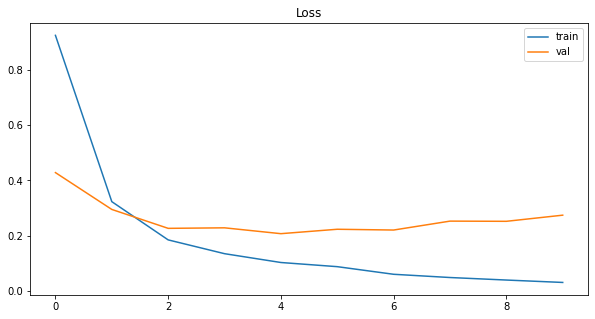

In [14]:
pd.DataFrame(losses_scores).plot(title='Loss',figsize=(10,5))

<AxesSubplot:title={'center':'Accuracy'}>

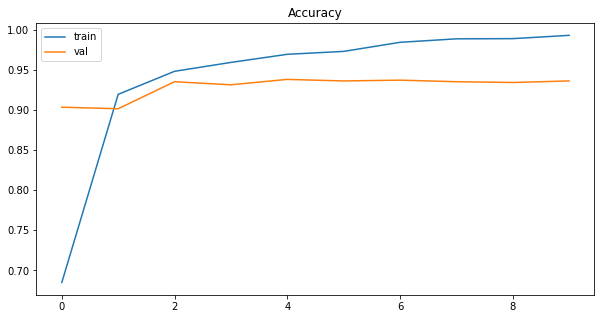

In [15]:
pd.DataFrame(accuracy_scores).plot(title='Accuracy',figsize=(10,5))

In [13]:
true_labels


[1,
 1,
 3,
 4,
 4,
 0,
 4,
 2,
 0,
 2,
 0,
 0,
 4,
 1,
 0,
 3,
 4,
 1,
 0,
 3,
 1,
 0,
 1,
 0,
 1,
 1,
 4,
 1,
 1,
 0,
 1,
 4,
 2,
 0,
 0,
 3,
 3,
 4,
 2,
 4,
 4,
 4,
 3,
 4,
 1,
 3,
 4,
 0,
 4,
 1,
 1,
 4,
 3,
 0,
 3,
 2,
 1,
 4,
 0,
 2,
 3,
 3,
 3,
 1,
 2,
 1,
 1,
 3,
 4,
 4,
 2,
 1,
 0,
 4,
 1,
 4,
 1,
 4,
 4,
 1,
 2,
 0,
 3,
 1,
 4,
 0,
 0,
 1,
 1,
 3,
 4,
 0,
 0,
 1,
 2,
 4,
 1,
 4,
 4,
 4,
 1,
 4,
 3,
 1,
 1,
 4,
 3,
 1,
 3,
 0,
 3,
 2,
 0,
 1,
 1,
 2,
 2,
 2,
 1,
 3,
 3,
 3,
 1,
 3,
 1,
 4,
 3,
 4,
 1,
 2,
 2,
 4,
 2,
 3,
 0,
 0,
 4,
 3,
 0,
 0,
 0,
 4,
 1,
 3,
 4,
 0,
 0,
 2,
 3,
 4,
 3,
 2,
 3,
 2,
 3,
 3]

In [14]:
false = [i for i in range(len(true_labels)) if true_labels[i]!=pred_labels[i]]
false

[4,
 5,
 9,
 13,
 14,
 15,
 16,
 26,
 32,
 36,
 38,
 43,
 48,
 52,
 56,
 64,
 70,
 72,
 73,
 83,
 85,
 92,
 94,
 97,
 102,
 111,
 113,
 115,
 116,
 117,
 120,
 125,
 126,
 127,
 129,
 130,
 132,
 144,
 147,
 148,
 152,
 153,
 154,
 155]

In [15]:
hate_df.iloc[val_idx[false]].to_csv(r'False.csv')